# Use Python <3.10

This package heavily utilizes the pyMuellerMat package that makes Mueller matrices from "system dictionaries" detailing the instrument configuration. Make sure to clone the physical_models branch of pyMuellerMat at https://github.com/maxwellmb/pyMuellerMat/.

In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator

# Plot settings that I like
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

# Step 1: Write FITS Info to CSV

In [9]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes/no_pick'
raw_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal/no_pick'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'
   write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin0_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin1_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin2_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin3_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin5_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin6_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/D

# Step 2 (Optional): Plot Your Data With the Original Model 

In [71]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea of goodness of
# fit, bin zero and lower bins can be finicky
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[-2.09034954e+08  3.94488401e+08  2.31232552e+08  3.92806254e+08
 -1.56772622e+08  3.94805602e+08  1.89615362e+08  3.92081635e+08
 -1.01002255e+07  3.91964053e+08]
Interleaved Stds
Length:  [3.94916458e-05 3.94228170e-05 3.71946193e-05 3.71060953e-05
 3.42015763e-05 3.42006128e-05 3.59514920e-05 3.58699608e-05
 4.13496916e-05 4.11426480e-05 3.67766771e-05 3.66891432e-05
 3.44701150e-05 3.44706220e-05 3.85727846e-05 3.84207266e-05
 4.56741344e-05 4.53929961e-05 3.88946415e-05 3.87325842e-05
 3.51568820e-05 3.51528516e-05 4.19241708e-05 4.17392306e-05
 5.00348351e-05 4.96283843e-05 4.31606009e-05 4.29424086e-05
 3.56464323e-05 3.56464484e-05 4.32193980e-05 4.30239612e-05
 5.08616030e-05 5.03975902e-05 4.73081651e-05 4.70459060e-05
 3.72154879e-05 3.72112104e-05 4.17011634e-05 4.14883349e-05
 4.76507977e-05 4.72076000e-05 4.80215390e-05 4.77296440e-05
 3.93357642e-05 3.93269802e-05 3.95655781e-05 3.93720339e-05
 4.36022006e-05 4.32069663e-05 4.50144906e-05 

In [12]:

# Define wavelength bins for CHARIS

wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits from Joost t Hart 2021

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[0.49996223 0.4998867  0.00869012 0.        ]
 [0.49996223 0.4998867  0.00869012 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


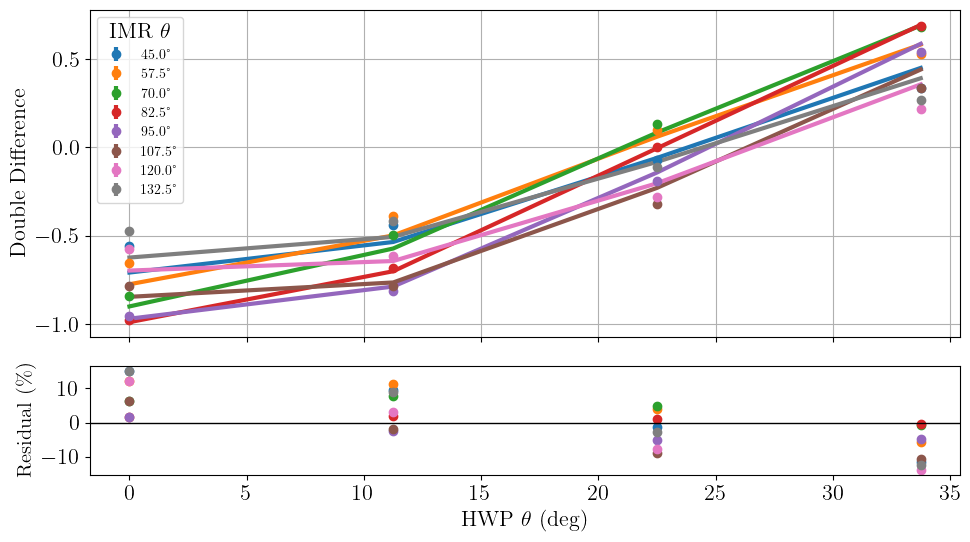

In [14]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins,1.64601,1.28540)[15], IMR_retardance(wavelength_bins,259.12694)[15]]


# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




# Step 3: Fit for Retardances

ABOUT THE FITTING FUNCTION/HOW I USE IT: I made a function that does everything quickly but is also tailored to the parameters I am fitting. My function fits using scipy least squares, updates the model, puts the pyMuellerMat compatible system dictionary in a JSON file, and optionally saves a plot of the model vs data to a specified path.
If you want to use it for different parameters than the ones in the p0 dictionary within the function, 
you'll have to update the function a bit (which shouldn't take too long). This is a wrapper function for the main minimization function in instruments.py. I've found it easier to use this function and tailor the parameters that it's fitting to what I need instead of using that fitting function. The things you need to edit in this function in instruments.py to fit new parameters are marked with all caps comments that look like this: # IF YOU WANT TO MODIFY YOUR PARAMETERS, EDIT THIS

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2906e+07                                    4.68e+07    
       1              2         2.6423e+07      2.65e+07       5.90e-02       1.08e+07    
       2              3         1.8743e+07      7.68e+06       2.40e-02       1.84e+06    
       3              4         1.7085e+07      1.66e+06       6.22e-03       1.20e+05    
       4              5         1.6966e+07      1.19e+05       7.35e-04       2.15e+04    
       5              6         1.6965e+07      6.71e+02       1.10e-04       3.42e+03    
       6              7         1.6965e+07      1.41e-01       1.74e-05       5.41e+02    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 5.2906e+07, final cost 1.6965e+07, first-order optimality 5.41e+02.
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.675e+03 -6.923

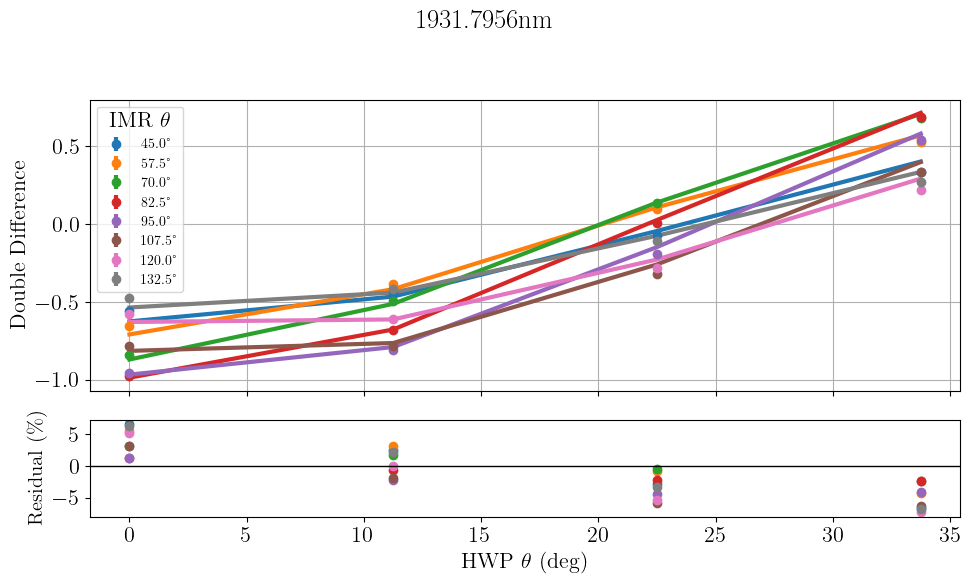

Updated Mueller Matrix:
[[ 0.30342331  0.30342331  0.          0.        ]
 [-0.30342331 -0.30342331  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.07336856458630558 0.06616037688012744
Error: [0.01750911 0.03987868]


/var/folders/2v/qmxm7kj51fg6kf7g36xrbysr0000gn/T/ipykernel_21397/1235663517.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [3]:
# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2 = fit_CHARIS_Mueller_matrix_by_bin(filepath, 15, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_cal/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



Looks like our model improved! Note that the Joost't Hart paper used a more elaborate physical model, which I will incorporate later. These fits are a good starting point for more detailed models. Now we can fit for all bins and collect the errors.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2657e+06                                    1.81e+07    
       1              2         4.9151e+05      3.77e+06       1.45e-01       3.90e+06    
       2              3         5.3012e+04      4.38e+05       6.08e-02       6.16e+05    
       3              4         3.4417e+04      1.86e+04       1.57e-02       3.48e+04    
       4              5         3.4350e+04      6.75e+01       9.91e-04       1.39e+02    
       5              6         3.4350e+04      1.11e-03       3.87e-06       1.53e-01    
       6              7         3.4350e+04      3.67e-09       1.50e-08       9.46e-04    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 7, initial cost 4.2657e+06, final cost 3.4350e+04, first-order optimality 9.46e-04.
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status

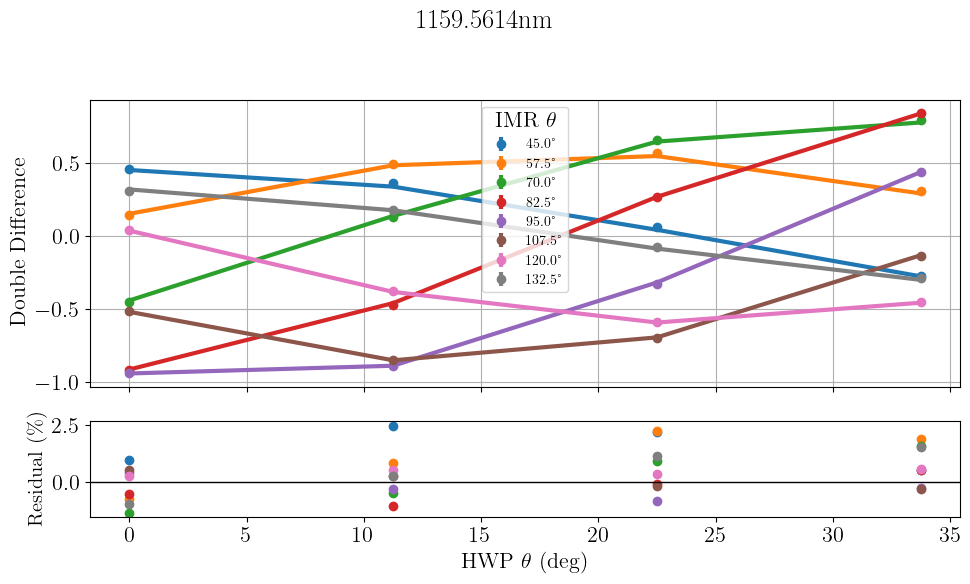

Updated Mueller Matrix:
[[ 0.69329451  0.69329451  0.          0.        ]
 [-0.69329451 -0.69329451  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.013071973520313307 0.024731759577429235
Error: [0.0037925  0.00817344]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1358e+06                                    2.14e+07    
       1              2         9.6137e+05      5.17e+06       1.60e-01       4.81e+06    
       2              3         1.9507e+05      7.66e+05       7.15e-02       9.30e+05    
       3              4         1.3223e+05      6.28e+04       2.70e-02       1.04e+05    
       4              5         1.3109e+05      1.14e+03       4.47e-03       2.38e+03    
       5              6         1.3109e+05      9.66e-01       1.84e-04       7.08e+01    
       6              7         1.31

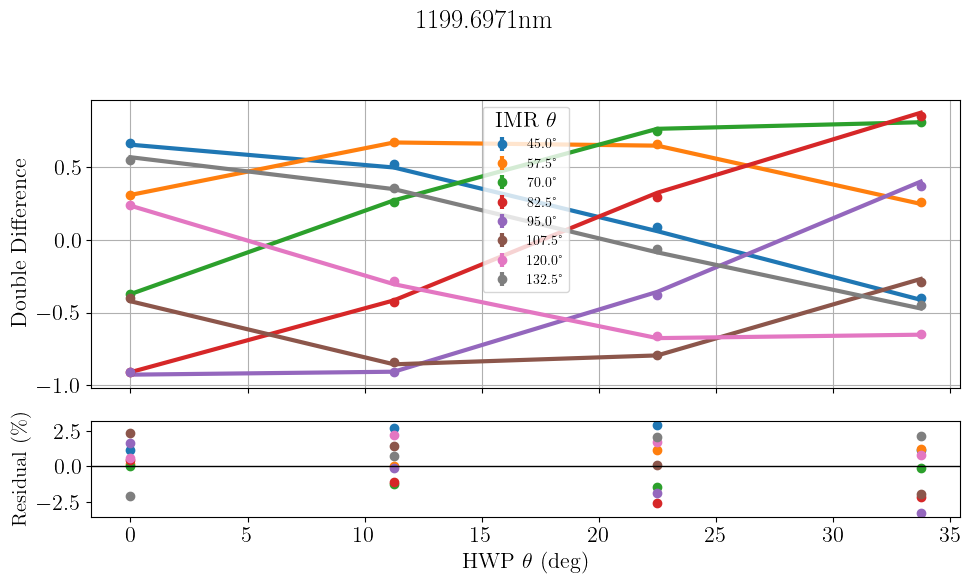

Updated Mueller Matrix:
[[ 0.76448389  0.76448389  0.          0.        ]
 [-0.76448389 -0.76448389  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.03246990721236592 0.0289445484052228
Error: [0.00770561 0.0164256 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1218e+06                                    1.27e+07    
       1              2         4.3814e+05      2.68e+06       1.37e-01       2.69e+06    
       2              3         1.0345e+05      3.35e+05       5.81e-02       4.58e+05    
       3              4         8.5030e+04      1.84e+04       1.73e-02       3.55e+04    
       4              5         8.4880e+04      1.51e+02       2.03e-03       5.17e+02    
       5              6         8.4879e+04      7.27e-02       7.25e-05       2.61e+01    
       6              7         8.4879e

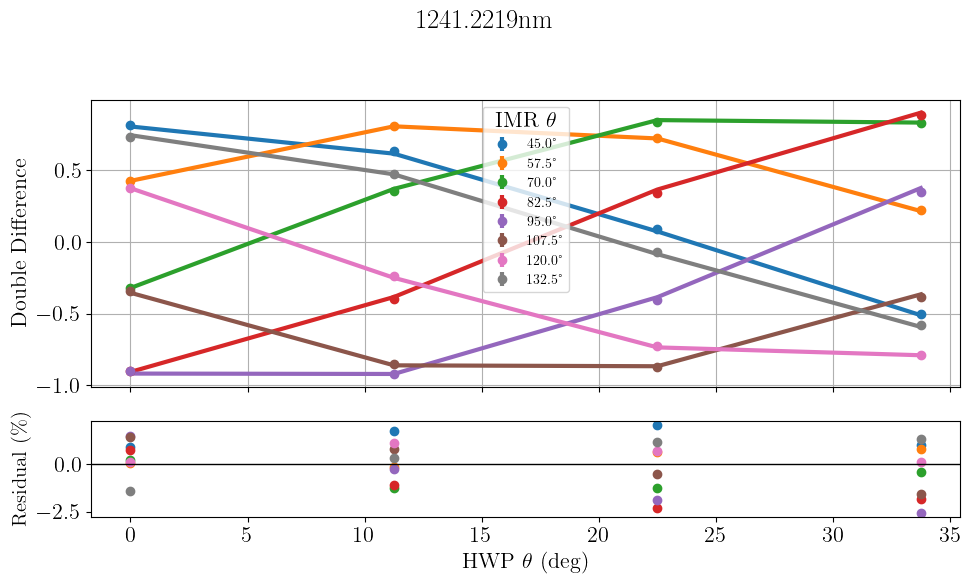

Updated Mueller Matrix:
[[ 0.81692665  0.81692665  0.          0.        ]
 [-0.81692665 -0.81692665  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.025386762342436087 0.020464509629623026
Error: [0.00734824 0.01540674]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8671e+05                                    4.38e+06    
       1              2         2.0483e+05      7.82e+05       1.11e-01       8.37e+05    
       2              3         1.2721e+05      7.76e+04       4.82e-02       1.06e+05    
       3              4         1.2406e+05      3.15e+03       1.47e-02       8.76e+03    
       4              5         1.2395e+05      1.08e+02       3.79e-03       1.78e+03    
       5              6         1.2395e+05      4.97e+00       8.31e-04       3.57e+02    
       6              7         1.23

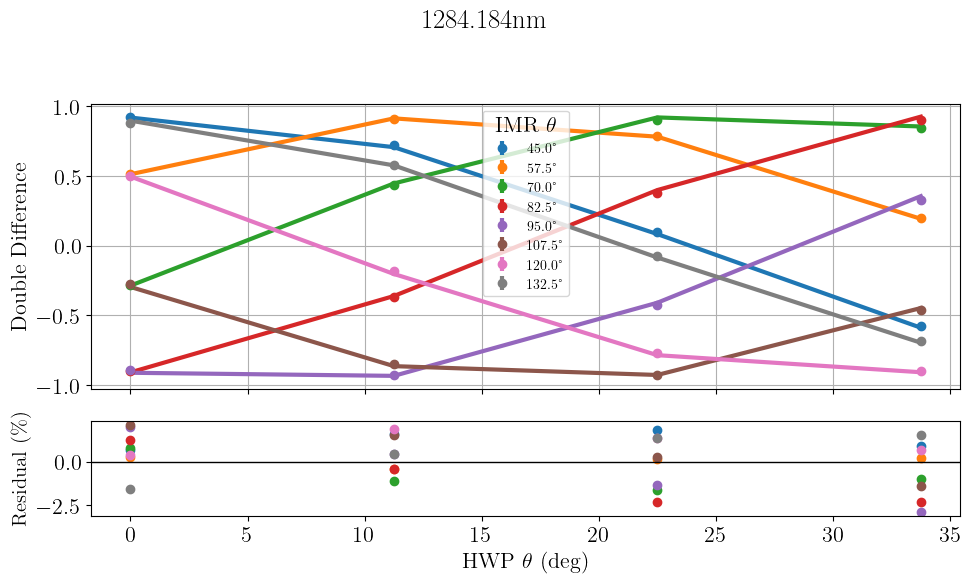

Updated Mueller Matrix:
[[ 0.85529767  0.85529767  0.          0.        ]
 [-0.85529767 -0.85529767  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.02848928868023537 0.02086396424866216
Error: [0.01256531 0.02618968]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4278e+05                                    3.83e+05    
       1              2         1.9764e+05      4.51e+04       5.91e-02       8.80e+04    
       2              3         1.6498e+05      3.27e+04       7.57e-02       7.90e+04    
       3              4         1.3527e+05      2.97e+04       6.57e-02       4.17e+04    
       4              5         1.2099e+05      1.43e+04       4.25e-02       1.77e+04    
       5              6         1.1392e+05      7.06e+03       2.93e-02       7.63e+03    
       6              7         1.1022

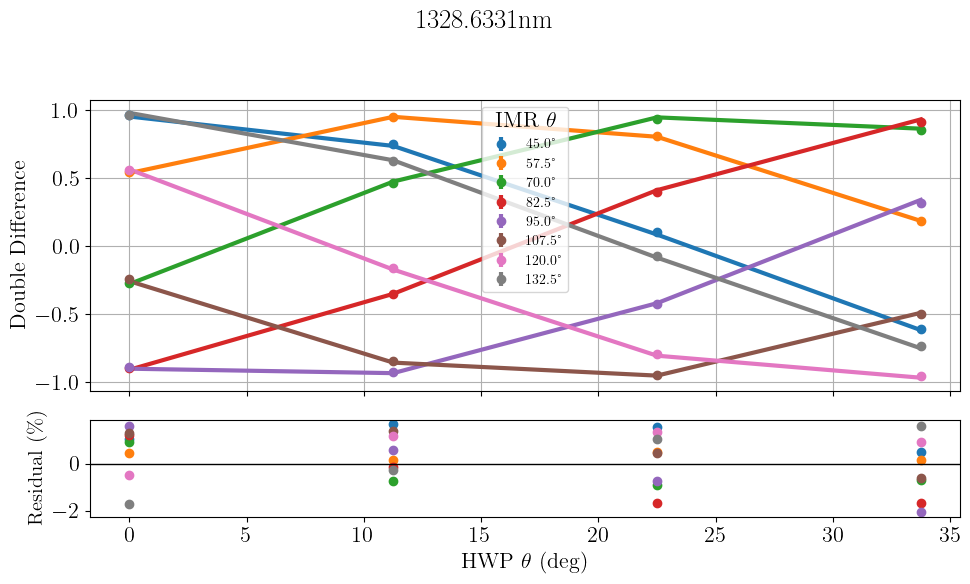

Updated Mueller Matrix:
[[ 0.86852361  0.86852361  0.          0.        ]
 [-0.86852361 -0.86852361  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.02081501529860924 0.016902482724205692
Error: [0.02258411 0.03996275]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0051e+06                                    7.35e+06    
       1              2         1.1409e+06      4.86e+06       1.87e-01       2.09e+06    
       2              3         6.6150e+05      4.79e+05       5.41e-02       6.71e+05    
       3              4         3.4163e+05      3.20e+05       7.94e-02       6.23e+05    
       4              5         2.3471e+05      1.07e+05       4.79e-02       2.59e+05    
       5              6         2.1816e+05      1.66e+04       1.97e-02       7.46e+04    
       6              7         2.168

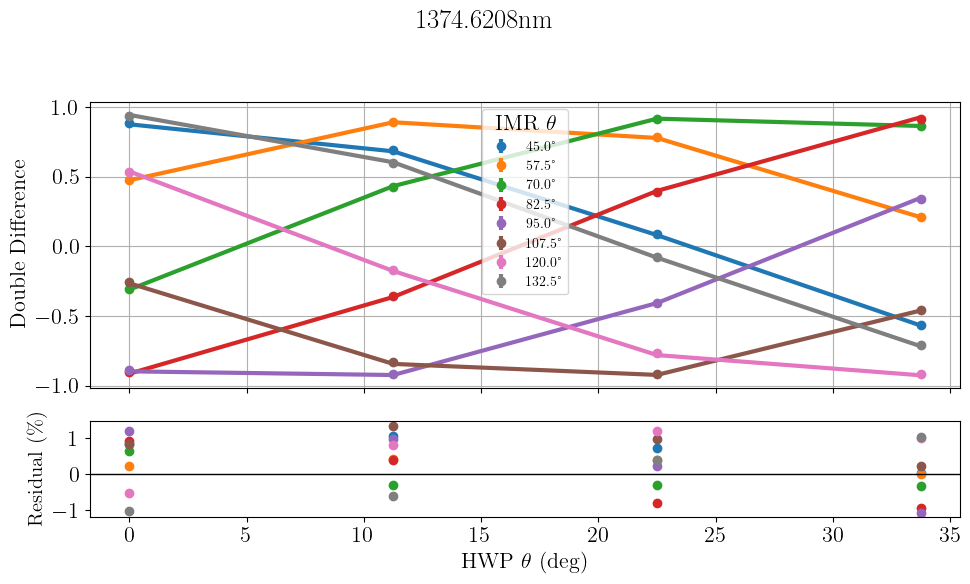

Updated Mueller Matrix:
[[ 0.84024574  0.84024574  0.          0.        ]
 [-0.84024574 -0.84024574  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.010728073663681337 0.013560427777359552
Error: [0.0077532  0.01464686]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1106e+06                                    1.44e+07    
       1              2         1.1522e+06      4.96e+06       1.23e-01       3.61e+06    
       2              3         2.7009e+05      8.82e+05       6.92e-02       8.36e+05    
       3              4         1.2390e+05      1.46e+05       4.01e-02       1.44e+05    
       4              5         1.1624e+05      7.66e+03       1.02e-02       1.48e+04    
       5              6         1.1617e+05      7.22e+01       1.16e-03       1.53e+03    
       6              7         1.16

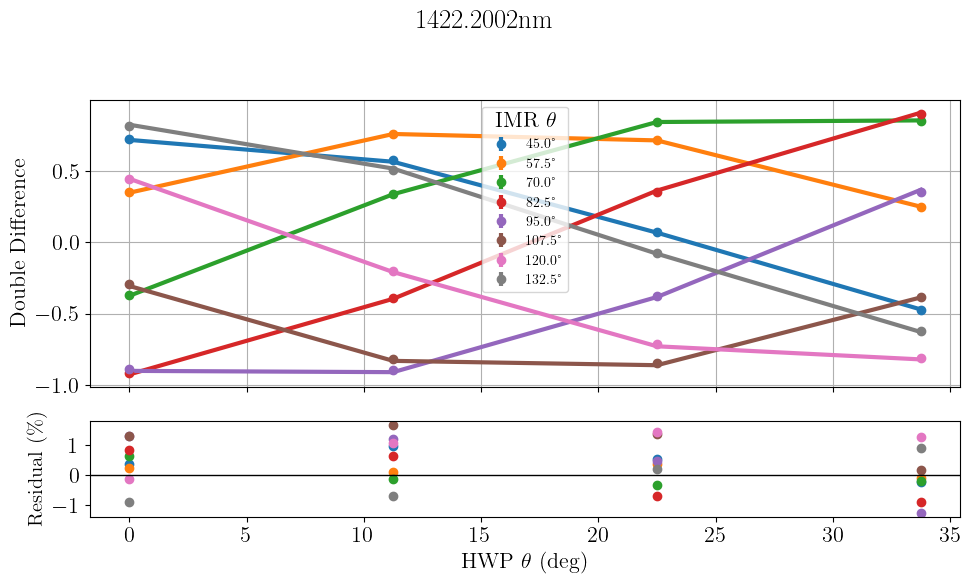

Updated Mueller Matrix:
[[ 0.78278612  0.78278612  0.          0.        ]
 [-0.78278612 -0.78278612  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.012399841230532282 0.01655839775761725
Error: [0.00468759 0.00954254]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8459e+06                                    2.16e+07    
       1              2         1.1079e+06      5.74e+06       8.76e-02       5.12e+06    
       2              3         1.5740e+05      9.51e+05       5.60e-02       1.01e+06    
       3              4         8.5621e+04      7.18e+04       1.74e-02       1.05e+05    
       4              5         8.4593e+04      1.03e+03       2.35e-03       2.20e+03    
       5              6         8.4592e+04      7.44e-01       8.59e-05       9.40e+01    
       6              7         8.459

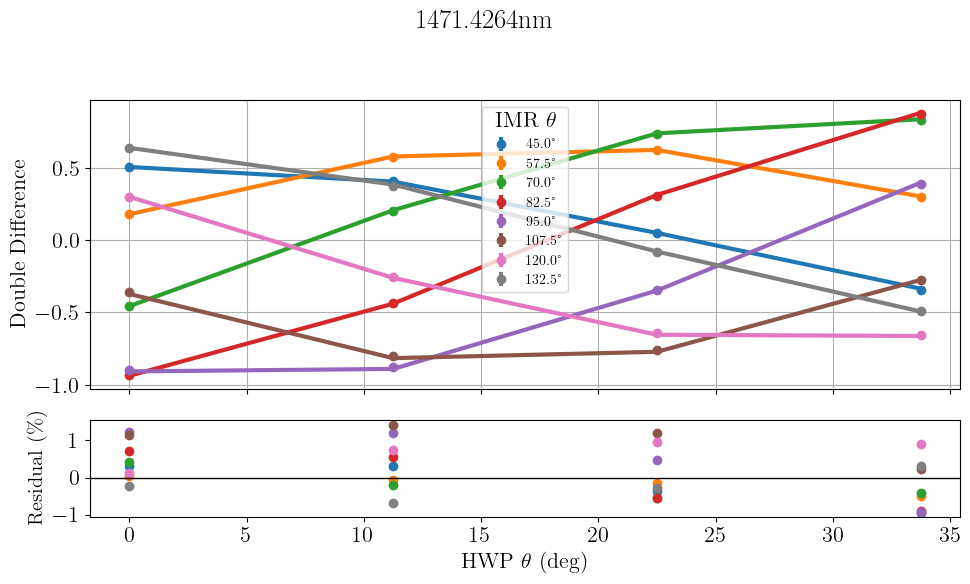

Updated Mueller Matrix:
[[ 0.70642987  0.70642987  0.          0.        ]
 [-0.70642987 -0.70642987  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.009415415310130126 0.014169781816012916
Error: [0.00281916 0.00596188]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7601e+06                                    1.90e+07    
       1              2         6.4046e+05      4.12e+06       6.94e-02       4.18e+06    
       2              3         1.3635e+05      5.04e+05       3.50e-02       6.46e+05    
       3              4         1.1773e+05      1.86e+04       7.53e-03       3.18e+04    
       4              5         1.1768e+05      5.53e+01       4.70e-04       4.34e+02    
       5              6         1.1768e+05      9.41e-03       9.40e-06       1.12e+01    
       6              7         1.17

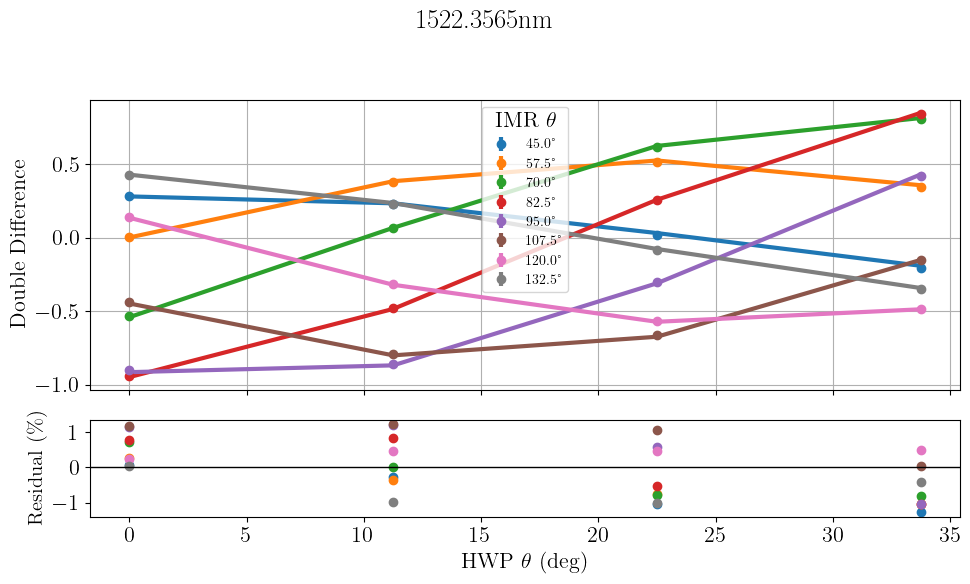

Updated Mueller Matrix:
[[ 0.6255319  0.6255319  0.         0.       ]
 [-0.6255319 -0.6255319  0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
128 64
Residuals range: -0.012751562759479224 0.01211122972020251
Error: [0.00283423 0.00613649]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4720e+06                                    9.65e+06    
       1              2         2.5297e+05      1.22e+06       4.96e-02       1.45e+06    
       2              3         2.1258e+05      4.04e+04       9.68e-03       6.59e+04    
       3              4         2.1248e+05      9.64e+01       5.11e-04       5.01e+02    
       4              5         2.1248e+05      8.34e-03       7.33e-06       9.14e+00    
       5              6         2.1248e+05      2.26e-06       1.23e-07       1.64e-01    
`ftol` termination condition is satisfied.
Function e

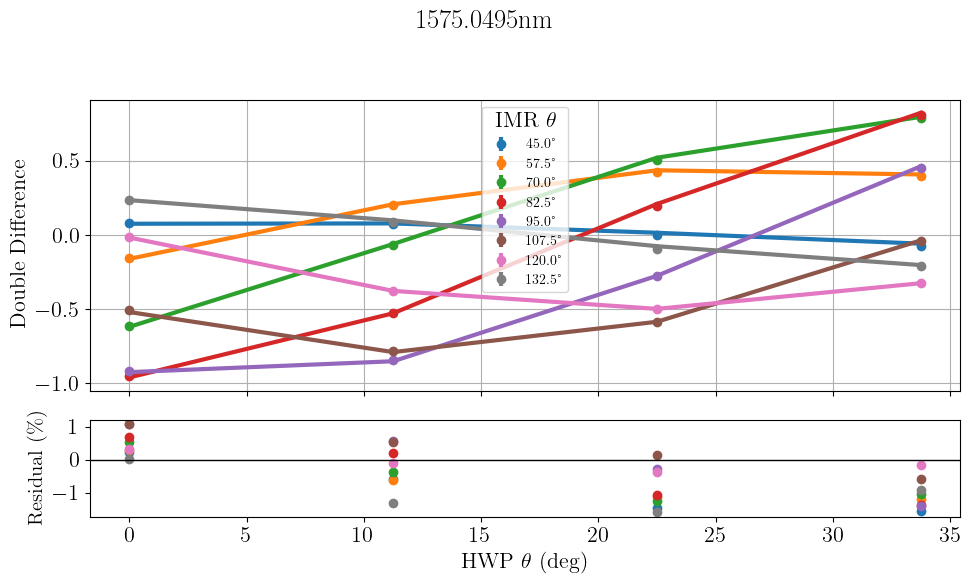

Updated Mueller Matrix:
[[ 0.55158471  0.55158471  0.          0.        ]
 [-0.55158471 -0.55158471  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.016006275886069024 0.01071141696618938
Error: [0.00311962 0.00687288]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8013e+05                                    4.50e+06    
       1              2         6.3841e+05      3.42e+05       3.52e-02       5.34e+05    
       2              3         6.3300e+05      5.41e+03       4.96e-03       2.01e+04    
       3              4         6.3299e+05      7.58e+00       1.89e-04       4.09e+02    
       4              5         6.3299e+05      3.12e-03       3.84e-06       8.00e+00    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.8013e+05, final cost 6.3299e+05, first-order o

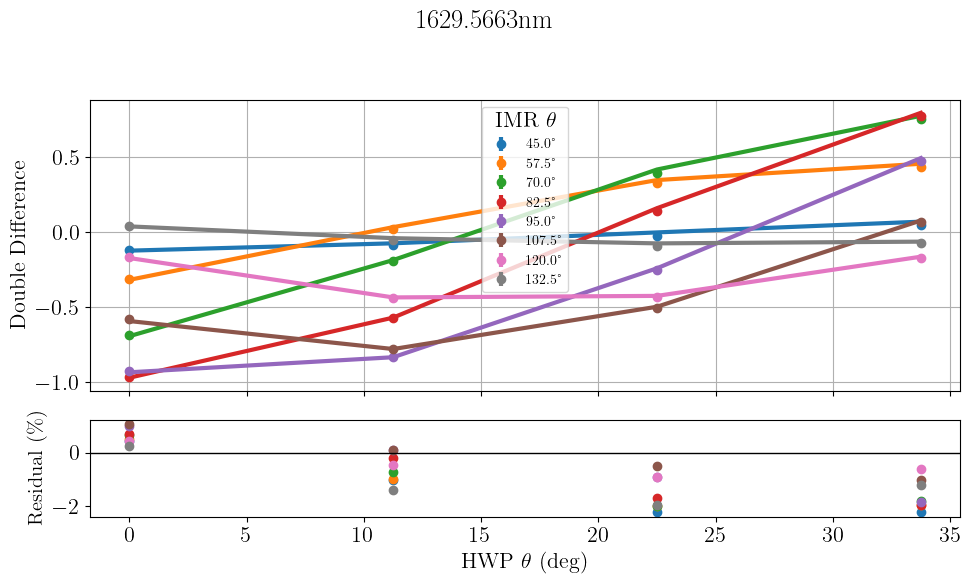

Updated Mueller Matrix:
[[ 0.48040555  0.48040555  0.          0.        ]
 [-0.48040555 -0.48040555  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.022415204396847438 0.010729702153439713
Error: [0.00449332 0.01003951]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0464e+06                                    7.77e+06    
       1              2         9.3101e+05      1.12e+06       4.09e-02       1.08e+06    
       2              3         9.0316e+05      2.78e+04       6.16e-03       4.22e+04    
       3              4         9.0312e+05      4.24e+01       2.23e-04       2.27e+02    
       4              5         9.0312e+05      1.10e-03       2.22e-06       4.30e+00    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.0464e+06, final cost 9.0312e+05, first-order 

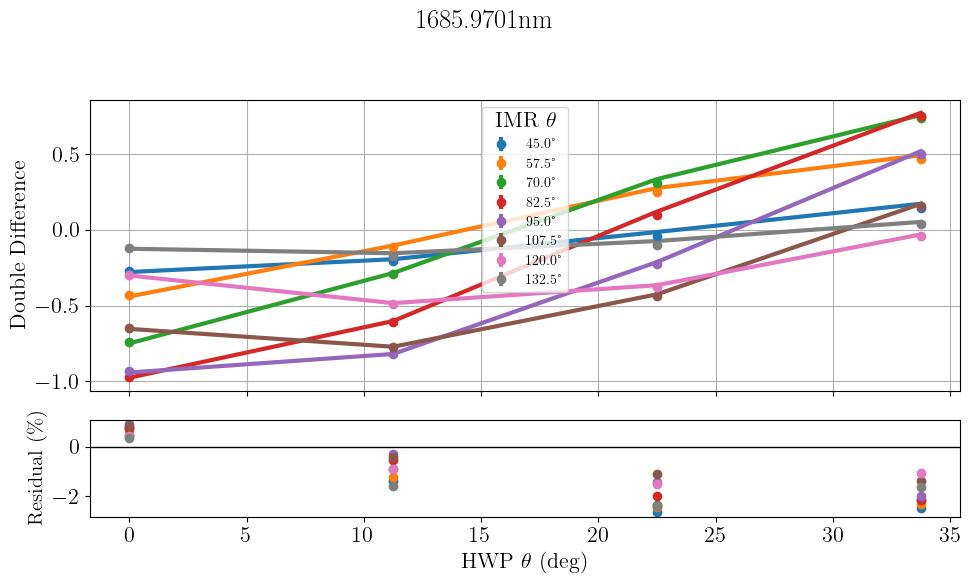

Updated Mueller Matrix:
[[ 0.42496794  0.42496794  0.          0.        ]
 [-0.42496794 -0.42496794  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.02667449697349418 0.009080965744047043
Error: [0.00557279 0.01257454]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5351e+06                                    1.59e+07    
       1              2         2.0095e+06      4.53e+06       5.64e-02       3.74e+06    
       2              3         1.3673e+06      6.42e+05       1.98e-02       7.33e+05    
       3              4         1.3186e+06      4.86e+04       6.41e-03       7.62e+04    
       4              5         1.3180e+06      6.85e+02       8.48e-04       1.31e+03    
       5              6         1.3180e+06      2.15e-01       1.59e-05       1.10e+01    
       6              7         1.318

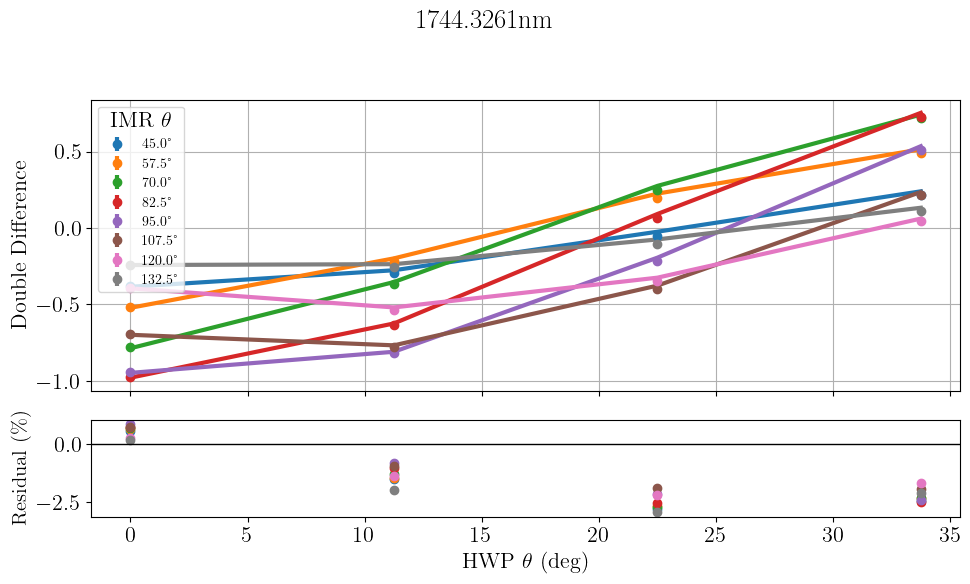

Updated Mueller Matrix:
[[ 0.3875842  0.3875842  0.         0.       ]
 [-0.3875842 -0.3875842  0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
128 64
Residuals range: -0.029364915384863743 0.008740668955090958
Error: [0.00674956 0.01534396]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2637e+07                                    3.52e+07    
       1              2         8.4740e+06      1.42e+07       6.06e-02       8.92e+06    
       2              3         4.9841e+06      3.49e+06       2.64e-02       2.24e+06    
       3              4         4.0892e+06      8.95e+05       1.30e-02       5.62e+05    
       4              5         3.8533e+06      2.36e+05       6.45e-03       1.40e+05    
       5              6         3.7884e+06      6.49e+04       3.18e-03       3.39e+04    
       6              7         3.7696e+06      1.88

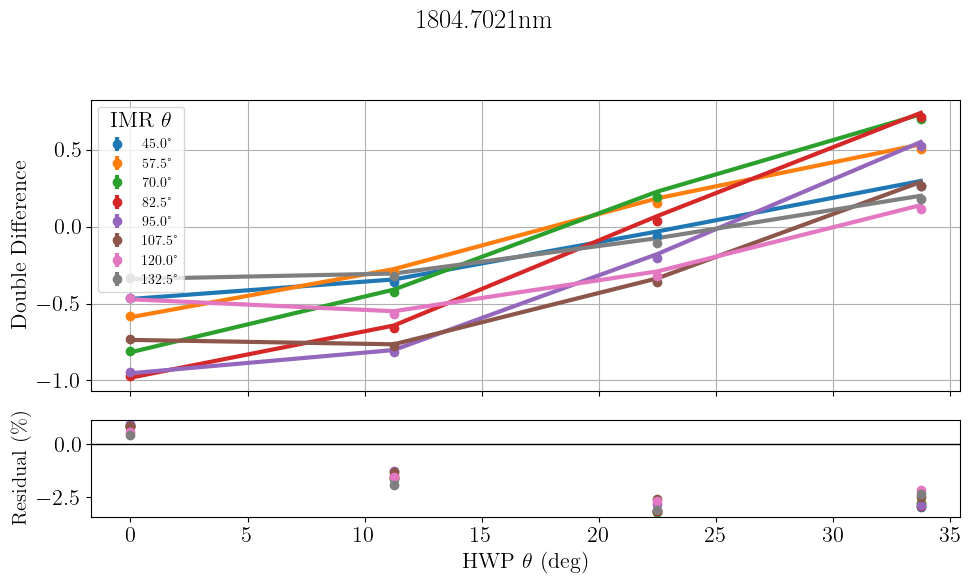

Updated Mueller Matrix:
[[ 0.35722909  0.35722909  0.          0.        ]
 [-0.35722909 -0.35722909  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.03247114682108718 0.009655099488109942
Error: [0.00857105 0.01951388]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.1531e+07                                    1.07e+08    
       1              2         3.9938e+07      5.16e+07       6.00e-02       2.64e+07    
       2              3         2.5189e+07      1.47e+07       2.62e-02       5.97e+06    
       3              4         2.0934e+07      4.26e+06       1.03e-02       9.85e+05    
       4              5         2.0041e+07      8.93e+05       2.50e-03       5.94e+04    
       5              6         1.9982e+07      5.90e+04       1.78e-04       3.27e+03    
       6              7         1.998

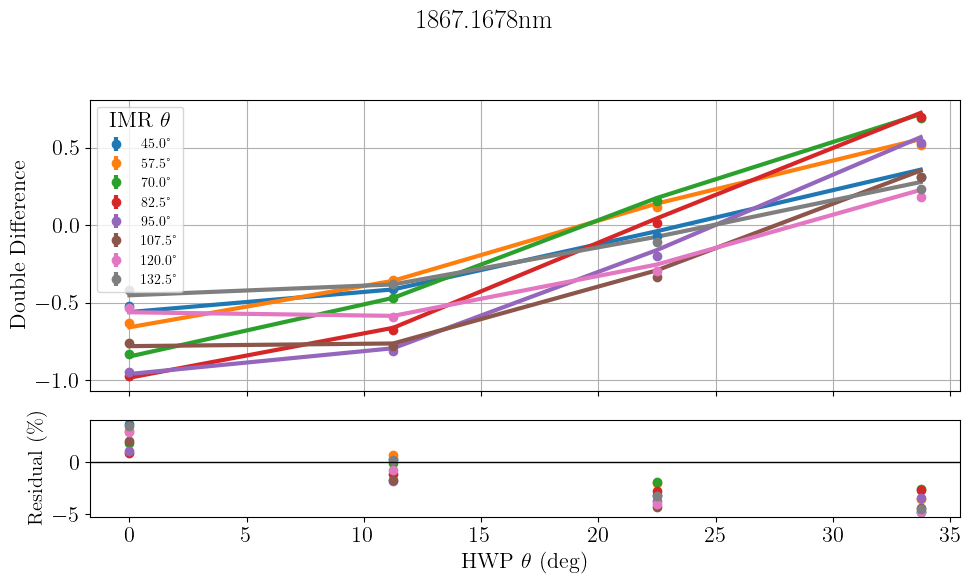

Updated Mueller Matrix:
[[ 0.32552977  0.32552977  0.          0.        ]
 [-0.32552977 -0.32552977  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04849568246192182 0.03656210411039518
Error: [0.01182078 0.02696699]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2906e+07                                    4.68e+07    
       1              2         2.6423e+07      2.65e+07       5.90e-02       1.08e+07    
       2              3         1.8743e+07      7.68e+06       2.40e-02       1.84e+06    
       3              4         1.7085e+07      1.66e+06       6.22e-03       1.20e+05    
       4              5         1.6966e+07      1.19e+05       7.35e-04       2.15e+04    
       5              6         1.6965e+07      6.71e+02       1.10e-04       3.42e+03    
       6              7         1.6965

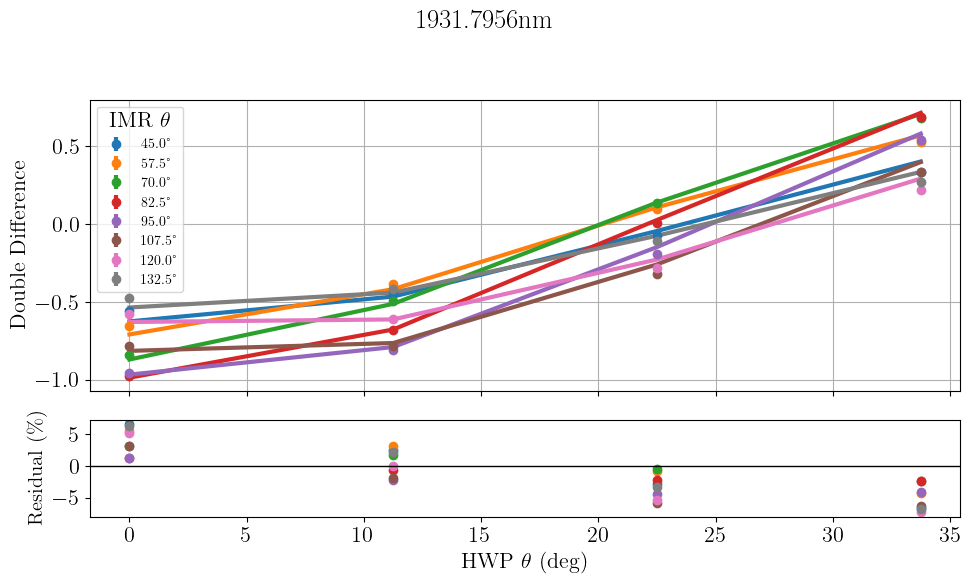

Updated Mueller Matrix:
[[ 0.30342331  0.30342331  0.          0.        ]
 [-0.30342331 -0.30342331  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.07336856458630558 0.06616037688012744
Error: [0.01750911 0.03987868]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3601e+07                                    3.70e+07    
       1              2         3.0108e+07      2.35e+07       5.80e-02       7.78e+06    
       2              3         2.3794e+07      6.31e+06       2.06e-02       9.35e+05    
       3              4         2.2889e+07      9.05e+05       4.30e-03       1.36e+05    
       4              5         2.2866e+07      2.30e+04       9.49e-04       3.51e+04    
       5              6         2.2866e+07      3.12e+01       2.44e-04       8.85e+03    
       6              7         2.2866

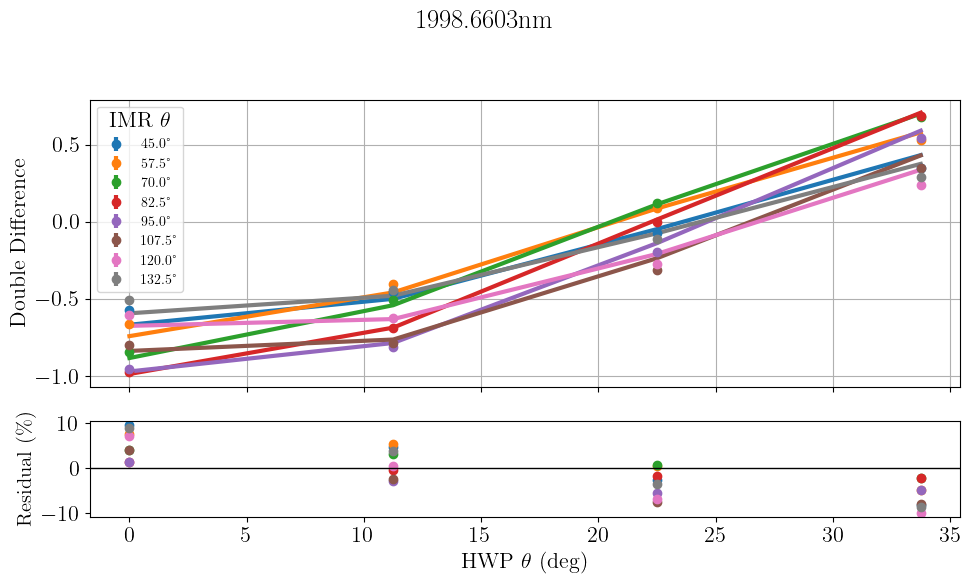

Updated Mueller Matrix:
[[ 0.28858776  0.28858776  0.          0.        ]
 [-0.28858776 -0.28858776  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.0988279851642952 0.09541213694612805
Error: [0.02432607 0.05540818]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5826e+07                                    3.26e+07    
       1              2         3.3699e+07      2.21e+07       5.78e-02       6.33e+06    
       2              3         2.8251e+07      5.45e+06       1.74e-02       5.82e+05    
       3              4         2.7677e+07      5.74e+05       3.26e-03       1.31e+05    
       4              5         2.7670e+07      7.39e+03       1.05e-03       4.63e+04    
       5              6         2.7670e+07      3.89e+01       3.75e-04       1.63e+04    
       6              7         2.7670e

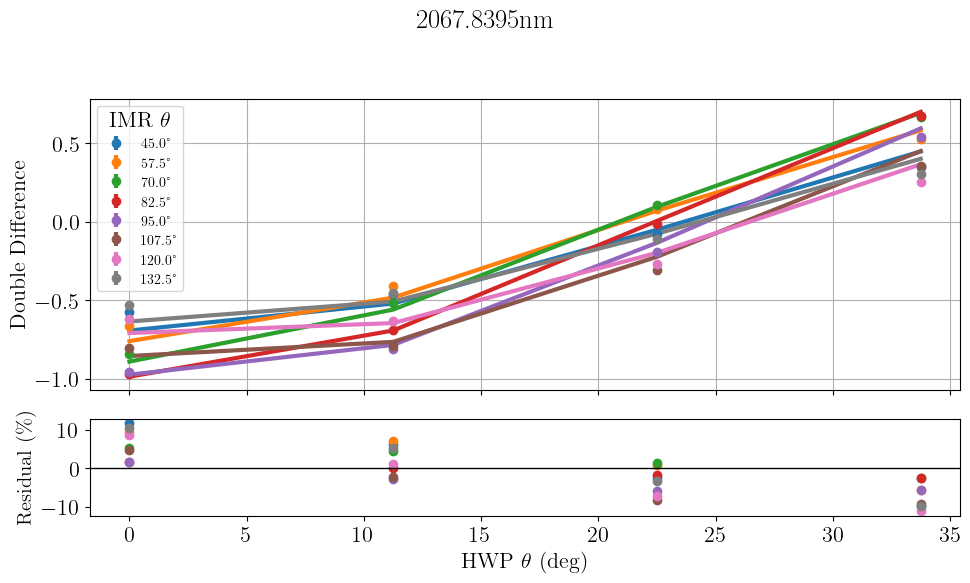

Updated Mueller Matrix:
[[ 0.28037201  0.28037201  0.          0.        ]
 [-0.28037201 -0.28037201  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.11226719929864054 0.11675004173134129
Error: [0.02963228 0.06736593]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0434e+07                                    2.64e+07    
       1              2         3.1706e+07      1.87e+07       5.76e-02       4.78e+06    
       2              3         2.7446e+07      4.26e+06       1.55e-02       3.56e+05    
       3              4         2.7093e+07      3.53e+05       2.44e-03       8.81e+04    
       4              5         2.7090e+07      2.82e+03       9.34e-04       3.76e+04    
       5              6         2.7090e+07      3.53e+01       4.00e-04       1.60e+04    
       6              7         2.7090

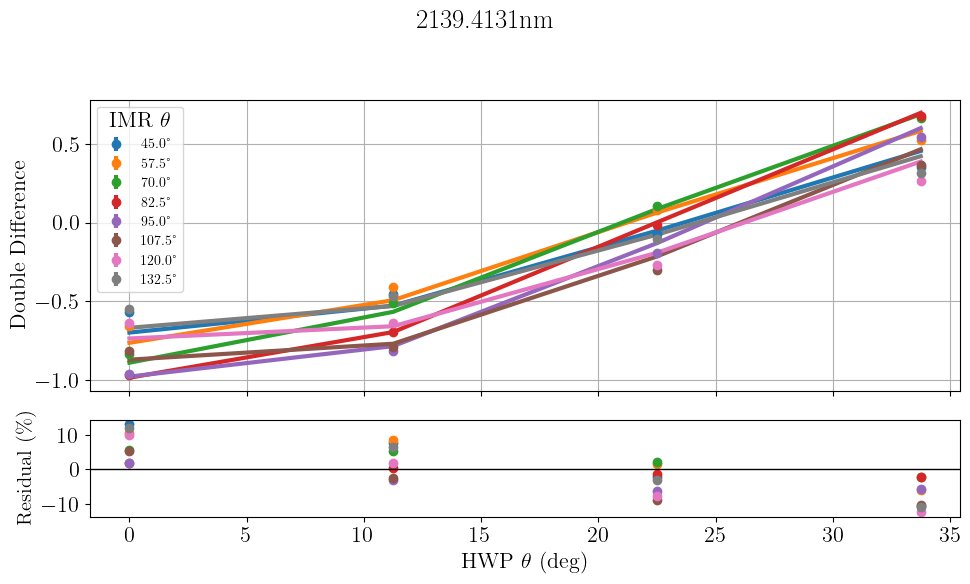

Updated Mueller Matrix:
[[ 0.27928333  0.27928333  0.          0.        ]
 [-0.27928333 -0.27928333  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.12452957969971007 0.1310391978347557
Error: [0.03367154 0.07662197]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4032e+07                                    2.54e+07    
       1              2         3.5251e+07      1.88e+07       5.85e-02       4.28e+06    
       2              3         3.1339e+07      3.91e+06       1.41e-02       2.55e+05    
       3              4         3.1084e+07      2.54e+05       2.06e-03       8.01e+04    
       4              5         3.1083e+07      1.36e+03       9.76e-04       4.21e+04    
       5              6         3.1083e+07      5.51e+01       5.16e-04       2.21e+04    
       6              7         3.1083e

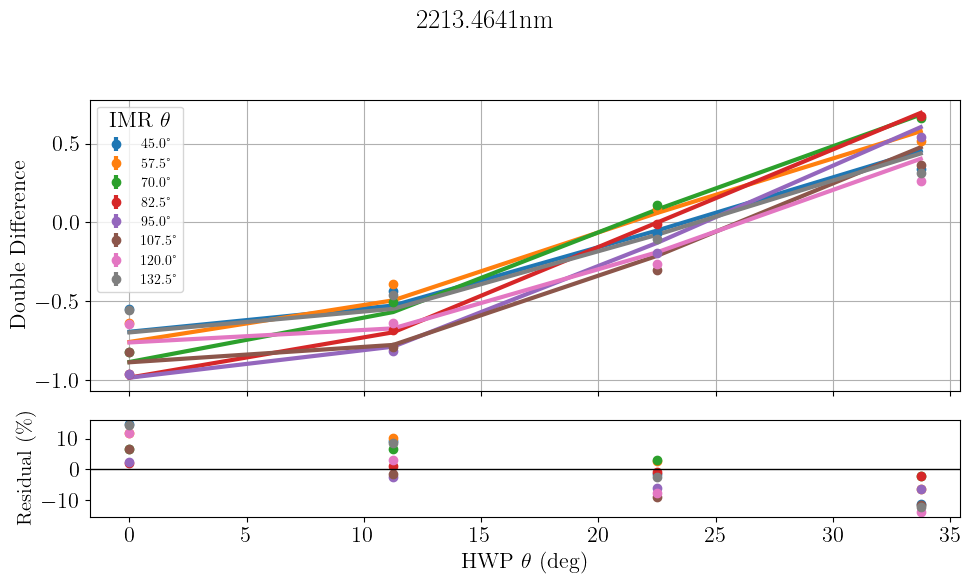

Updated Mueller Matrix:
[[ 0.28282192  0.28282192  0.          0.        ]
 [-0.28282192 -0.28282192  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13969565476845902 0.1462994878976086
Error: [0.03855781 0.08748338]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0045e+07                                    1.82e+07    
       1              2         2.6338e+07      1.37e+07       6.49e-02       3.00e+06    
       2              3         2.3562e+07      2.78e+06       1.85e-02       3.47e+05    
       3              4         2.3386e+07      1.76e+05       6.54e-03       1.86e+05    
       4              5         2.3383e+07      2.84e+03       3.66e-03       1.03e+05    
       5              6         2.3382e+07      6.30e+02       2.08e-03       5.77e+04    
       6              7         2.3382e

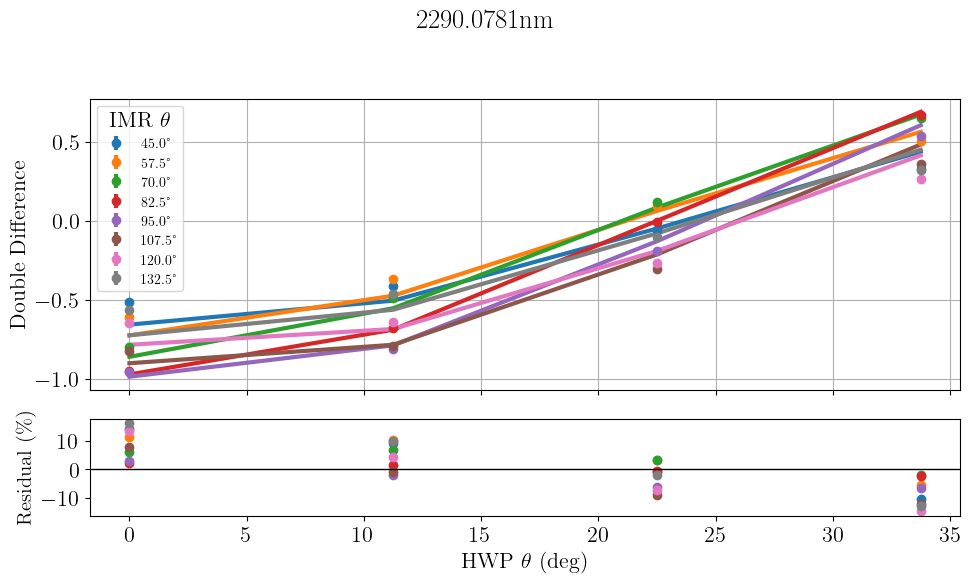

Updated Mueller Matrix:
[[ 0.2960342  0.2960342  0.         0.       ]
 [-0.2960342 -0.2960342  0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
128 64
Residuals range: -0.14924619925303834 0.1615856286723678
Error: [0.04077482 0.09240579]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8707e+07                                    2.05e+07    
       1              2         3.2926e+07      1.58e+07       6.86e-02       3.23e+06    
       2              3         2.9897e+07      3.03e+06       1.89e-02       4.10e+05    
       3              4         2.9724e+07      1.73e+05       7.32e-03       2.46e+05    
       4              5         2.9720e+07      4.31e+03       4.65e-03       1.55e+05    
       5              6         2.9719e+07      1.45e+03       3.00e-03       9.82e+04    
       6              7         2.9718e+07      5.93e+0

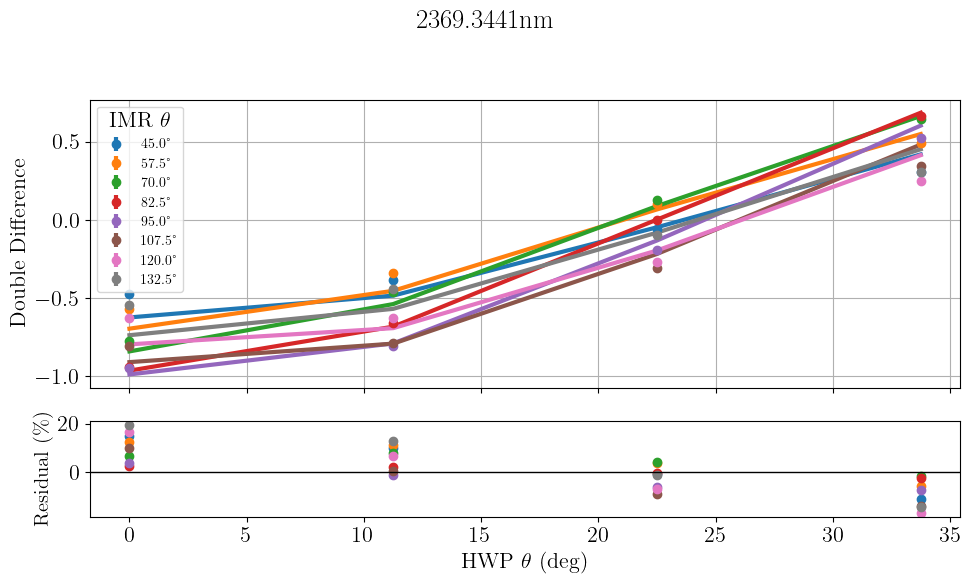

Updated Mueller Matrix:
[[ 0.3081517  0.3081517  0.         0.       ]
 [-0.3081517 -0.3081517  0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
128 64
Residuals range: -0.16789611698902734 0.19382043059950138
Error: [0.04644951 0.10266078]


In [2]:
# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
    error = fit_CHARIS_Mueller_matrix_by_bin(
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets/sysdictbin{bin}nopick.json'),
        plot_path=Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/plots_justrets/bin{bin}nopick.png')
    )[0]
    errors.append(error)


In [3]:
# find average error
errors = np.array(errors)
print('hwp_ret', np.mean(errors[:,0]))
print('imr_ret',np.mean(errors[:,1]))



    

hwp_ret 0.015606283017086366
imr_ret 0.03434465591058628


In [4]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets'
df = model_data(json_dir)
df

,wavelength_bin,hwp_retardance,imr_retardance
0,1159.5614,3.002347,4.312646
1,1199.6971,3.035810,4.047440
2,1241.2219,3.047753,3.818063
3,1284.1840,3.089012,3.567605
4,1328.6331,3.257679,3.363741
5,1374.6208,2.979060,2.733409
6,1422.2002,2.979265,2.462469
7,1471.4264,2.986124,2.186836
8,1522.3565,2.989187,1.937871
9,1575.0495,2.986980,1.728039


# Step 4: Refine Retardance Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [5]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [7]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,1]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1136.7157580906196
        x: [ 1.667e+00  1.301e+00  2.583e+02]
      nit: 11
      jac: [-4.366e-03  9.231e-03 -4.547e-04]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1136.7157580906196
        x: [ 1.667e+00  1.301e+00  2.583e+02]
      nit: 1
      jac: [-4.366e-03  9.231e-03 -4.547e-04]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


That's It! The fit is updated. However, in the Hart 2021 paper, a degeneracy in wavelength bin 4 was noted. Because of this, I will redo the fit to see if the model fits better. 

In [61]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,1]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 984.8440470789837
        x: [ 1.669e+00  1.303e+00  2.583e+02]
      nit: 11
      jac: [-6.128e-03  1.112e-02  4.775e-04]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 984.8440470789837
        x: [ 1.669e+00  1.303e+00  2.583e+02]
      nit: 1
      jac: [-6.128e-03  1.112e-02  4.775e-04]
     nfev: 44
     njev: 11
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [10]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 4148.070006005612
Our model with all bins: 1136.7157580906196
Our model without bin 4: 984.8440470789837


In [13]:
print(1.268*1.2)

1.5216


# Step 5: Fit for Offsets Globally

In [62]:
# Get interleaved values for all wavelength bins
csvdir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)


wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = 
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 258.3
wsio2 = 1.667
wmgf2 = 1.301

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": 0},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": 0},
    "lprot" : 
        {"pa": 0},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])

# Process everything into double differences and propagate errors

diff_errors = process_errors(interleaved_stds_all,interleaved_values_all)[::2]
diffs = process_dataset(interleaved_values_all)[::2]



In [66]:
# Minimize everything globally with minimize

result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds],mode='minimize')
print(result_min)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 564636139.786266
        x: [ 2.646e+02 -2.406e-01  1.650e+00  1.288e+00 -3.860e+00
             4.268e+00]
      nit: 87
      jac: [ 2.146e+02 -1.025e+03  8.911e+04 -1.055e+05  7.606e+03
             4.017e+03]
     nfev: 861
     njev: 123
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [63]:
# Minimize everything globally with least squares
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result, logl,error = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,(-5,5)],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1250e+09                                    5.23e+09    
       1              2         6.0015e+08      5.25e+08       5.26e+00       1.07e+09    
       2              3         5.6736e+08      3.28e+07       1.30e+00       4.92e+08    
       3              4         5.6638e+08      9.75e+05       3.31e-01       7.14e+07    
       4              5         5.6539e+08      9.98e+05       2.08e+00       2.57e+08    
       5              6         5.6488e+08      5.05e+05       1.91e+00       2.28e+08    
       6              7         5.6474e+08      1.45e+05       8.17e-01       9.85e+07    
       7              8         5.6467e+08      6.96e+04       3.93e-01       4.69e+07    
       8              9         5.6464e+08      2.30e+04       2.25e-01       2.56e+07    
       9             10         5.6464e+08      6.02e+03       1.57e-01       1.61e+07    

In [48]:
# Constrain offsets more
offset_bounds2 = (-1,1)
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result2, logl2,error2 = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds2,wsio2_bounds,wmgf2_bounds,offset_bounds2,offset_bounds2],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1168e+09                                    5.19e+09    
       1              2         6.9445e+08      4.22e+08       5.01e+00       7.30e+08    
       2              3         6.0847e+08      8.60e+07       1.29e+00       4.08e+08    
       3              4         5.8261e+08      2.59e+07       3.79e-01       2.09e+08    
       4              5         5.7468e+08      7.93e+06       1.45e-01       9.32e+07    
       5              6         5.7240e+08      2.28e+06       5.23e-02       3.55e+07    
       6              7         5.7201e+08      3.86e+05       1.01e-02       8.09e+06    
       7              8         5.7200e+08      1.41e+04       7.43e-04       8.79e+05    
       8              9         5.7200e+08      1.71e+01       1.14e-04       8.62e+04    
       9             10         5.7200e+08      6.32e-02       2.04e-05       9.23e+03    

In [65]:
print(result.x)
print(error)

[ 2.64612183e+02 -2.40636182e-01  1.65023099e+00  1.28855184e+00
 -3.85508215e+00  4.25908363e+00]
[0.33345063 0.10969638 0.01705139 0.01252802 1.1434068  2.26894248]


In [ ]:


offset_imr2 = 0.13214 # derotator offset
offset_hwp2 = -0.99287 # HWP offset
offset_cal2 = 0.49797 # calibration polarizer offset


# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm2 = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

